# Lecture 5:  MultLinearRegression
### Data Science 1: CS 109A/STAT 121A/AC 209A/ E 109A <br> Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine
#### Harvard University <br> Fall 2017 <br> 

---


In [75]:
import pandas as pd
import sys
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
sns.set(style="ticks")
%matplotlib inline


import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

In [76]:
def find_regression_params(regression_model, samples, cols):
    nyc_cab_sample = nyc_cab_df.sample(n=samples)

    y = nyc_cab_sample['Fare_amount'].values
    X = nyc_cab_sample[cols].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    regression_model.fit(X_train, y_train)
    
    return np.hstack((np.array([regression_model.intercept_]), regression_model.coef_))

### PLOTTING ROUTINE FOR HIST 
def plot_hist_se(vals, bins, title, xlabel, ax):
    mean = vals.mean()
    std = vals.std()
    ax.hist(vals, bins=bins, color='blue', edgecolor='white', linewidth=1, alpha=0.2)
    ax.axvline(mean, color='red', label='mean = {0:.2f}'.format(mean))
    ax.axvline(mean - 2 * std, color='green', linestyle='--', label='std = {0:.2f}'.format(std))
    ax.axvline(mean + 2 * std, color='green', linestyle='--')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend(loc='best')


    return ax

## Residual Analysis

In [77]:
nyc_cab_df = pd.read_csv('data/nyc_car_hire_data.csv', low_memory=False)

In [78]:
nyc_cab_sample = nyc_cab_df.sample(n=1000, random_state=2)

y = nyc_cab_sample['Fare_amount'].values
X = nyc_cab_sample['Trip Length (min)'].values

X_train, X_test, y_train, y_test = train_test_split(X.reshape((len(X), 1)), y, test_size=0.33, random_state=0)

regression = LinearRegression(fit_intercept=True)
regression.fit(X_train, y_train)

regression_line = lambda x: regression.intercept_ + regression.coef_ * x
print('The equation of the regression line is: {} + {} * x'.format(regression.intercept_, regression.coef_[0]))

The equation of the regression line is: 6.470468317419149 + 0.7164786391058202 * x


In [79]:
train_R_sq = regression.score(X_train, y_train)
test_R_sq = regression.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train R^2 is 0.43757715681817544, the test R^2 is 0.37689502630798666


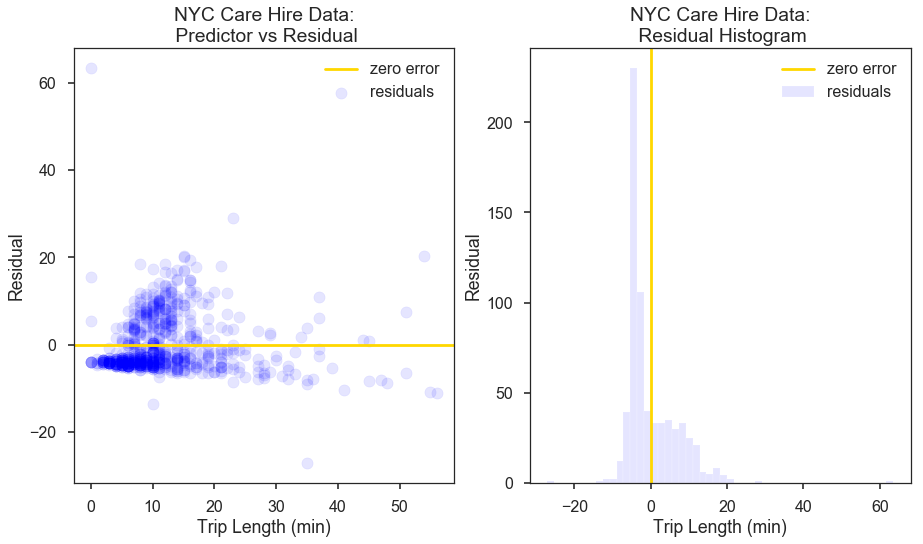

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

errors = y_train - regression.predict(X_train)
ax[0].scatter(X_train, errors, color='blue', alpha=0.1, label='residuals')
ax[0].axhline(y=0, color='gold', label='zero error')


ax[0].set_xlabel('Trip Length (min)')
ax[0].set_ylabel('Residual')
ax[0].set_title('NYC Care Hire Data:\n Predictor vs Residual')
ax[0].legend(loc='best')

ax[1].hist(errors, color='blue', alpha=0.1, label='residuals', bins=50, edgecolor='white', linewidth=2)
ax[1].axvline(x=0, color='gold', label='zero error')


ax[1].set_xlabel('Trip Length (min)')
ax[1].set_ylabel('Residual')
ax[1].set_title('NYC Care Hire Data:\n Residual Histogram')
ax[1].legend(loc='best')




---

## Multiple Linear Regression

In [83]:
nyc_cab_sample = nyc_cab_df.sample(n=1000, random_state=2)
nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
msk = np.random.rand(len(nyc_cab_sample)) < 0.8
train = nyc_cab_sample[msk]
test = nyc_cab_sample[~msk]

y_train = train['Fare_amount'].values
X_train = train[['Trip Length (min)', 'Type', 'TMAX']].values

y_test = test['Fare_amount'].values
X_test = test[['Trip Length (min)', 'Type', 'TMAX']].values

In [84]:
multi_regression_model = LinearRegression(fit_intercept=True)
multi_regression_model.fit(X_train, y_train)

print('The equation of the regression plane is: {} + {}^T . x'.format(multi_regression_model.intercept_, multi_regression_model.coef_))

The equation of the regression plane is: 2.2015204509366235 + [  7.78255014e-01   9.73861853e+00   7.98916964e-03]^T . x


### 1. Train vs Test Error

In [85]:
train_MSE= np.mean((y_train - multi_regression_model.predict(X_train))**2)
test_MSE= np.mean((y_test - multi_regression_model.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = multi_regression_model.score(X_train, y_train)
test_R_sq = multi_regression_model.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train MSE is 23.25038469966132, the test MSE is 14.181236821686534
The train R^2 is 0.6828758903518493, the test R^2 is 0.8102815055746478


### 3. Uncertainty in the Model Parameter Estimates

In [86]:
total_draws = 500
samples = 1000
regression_params = []

for i in range(total_draws):
    if i % 10 == 0:
        out = i * 1. / total_draws * 100
        sys.stdout.write("\r%d%%" % out)
        sys.stdout.flush()
        
    regression_params.append(find_regression_params(multi_regression_model, samples, ['Trip Length (min)', 'Type', 'TMAX']))
    
sys.stdout.write("\r%d%%" % 100)
regression_params = np.array(regression_params)

100%

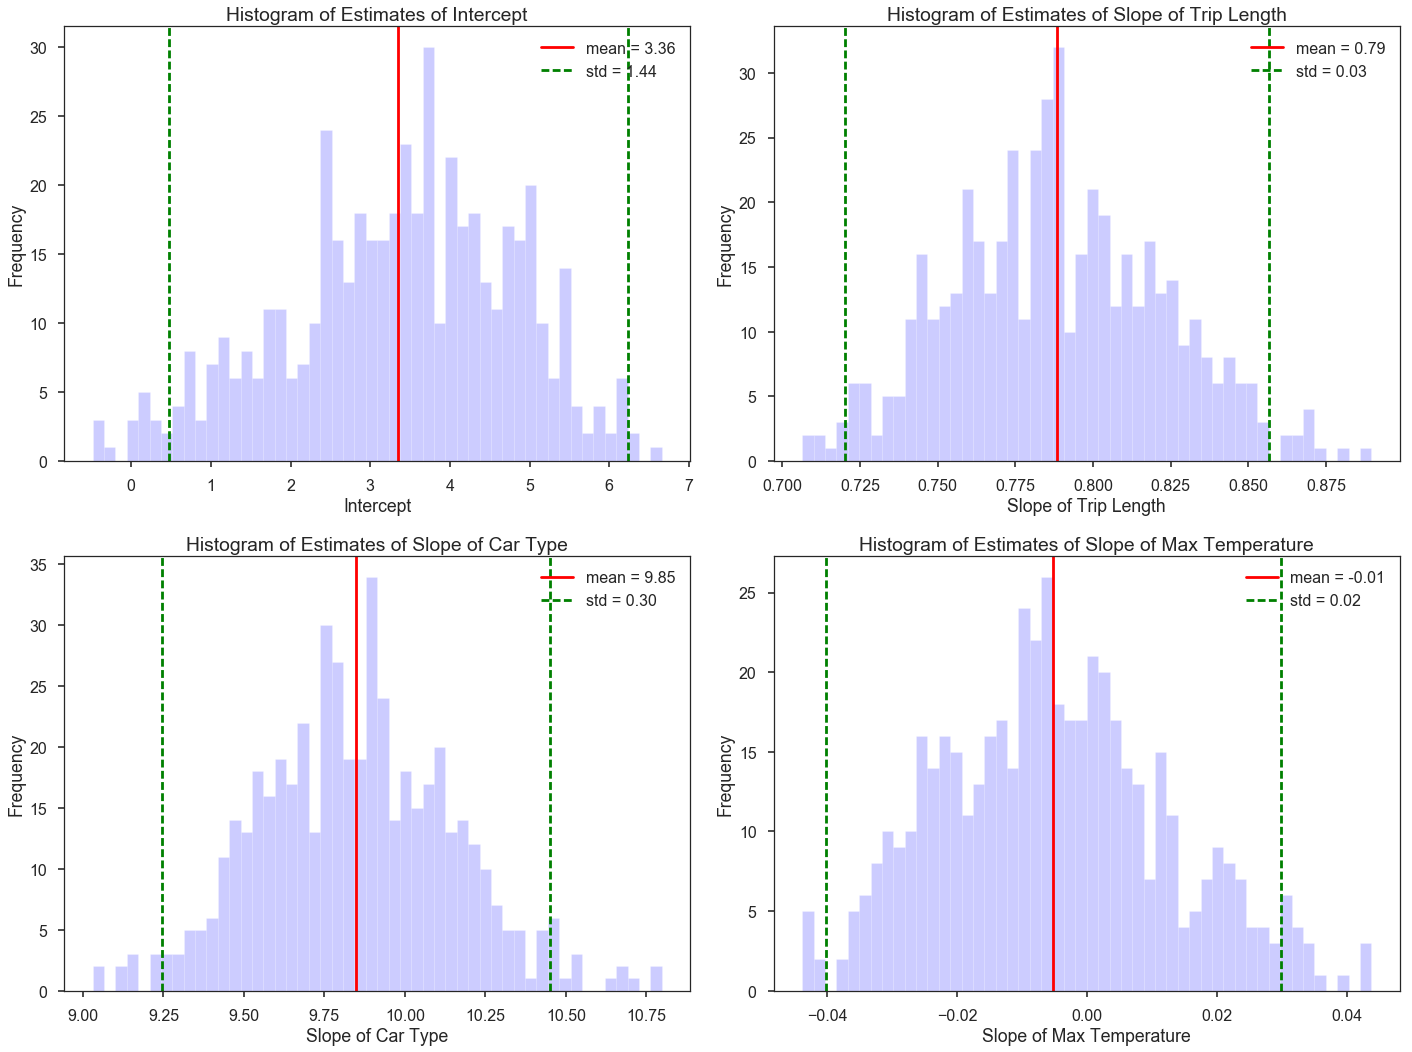

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))


plot_hist_se(regression_params[:, 0], 50, 'Histogram of Estimates of Intercept', 'Intercept', ax[0,0])
plot_hist_se(regression_params[:, 1], 50, 'Histogram of Estimates of Slope of Trip Length', 'Slope of Trip Length', ax[0,1])
plot_hist_se(regression_params[:, 2], 50, 'Histogram of Estimates of Slope of Car Type', 'Slope of Car Type', ax[1,0])
plot_hist_se(regression_params[:, 3], 50, 'Histogram of Estimates of Slope of Max Temperature', 'Slope of Max Temperature', ax[1,1])

plt.tight_layout()
plt.show()

---

## Evaluating the Significance of Predictors

In [88]:
predictors_multiple = ['Trip Length (min)', 'Type', 'TMAX']
predictors_simple = ['Trip Length (min)']

X_train_multi = add_constant(train[predictors_multiple].values)
X_test_multi = add_constant(test[predictors_multiple].values)

X_train_simple = add_constant(train[predictors_simple].values)
X_test_simple = add_constant(test[predictors_simple].values)

### 1. Measuring Significance Using F-Stat, p-Values

In [89]:
multi_regression_model = sm.OLS(y_train, X_train_multi).fit()
print('F-stat:', multi_regression_model.fvalue)
print('p-values: {} (intercept), {} (Trip Length), {} (Type), {} (TMAX)'.format(*multi_regression_model.pvalues))

F-stat: 554.126046462
p-values: 0.08308352287005023 (intercept), 2.8746696419039935e-155 (Trip Length), 1.190782856531774e-106 (Type), 0.6886271205673032 (TMAX)


### 2. Measuring Significance Using AIC/BIC

In [90]:
print("AIC for ['Trip Length (min)', 'Type', 'TMAX']:", multi_regression_model.aic)
print("BIC for ['Trip Length (min)', 'Type', 'TMAX']:", multi_regression_model.bic)

AIC for ['Trip Length (min)', 'Type', 'TMAX']: 4651.73822575
BIC for ['Trip Length (min)', 'Type', 'TMAX']: 4670.35483583


In [91]:
simple_regression_model = sm.OLS(y_train, X_train_simple).fit()
print("AIC for ['Trip Length (min)']:", simple_regression_model.aic)
print("BIC for ['Trip Length (min)']:", simple_regression_model.bic)

AIC for ['Trip Length (min)']: 5131.75231861
BIC for ['Trip Length (min)']: 5141.06062365


### 3. Measuring Significance Using R^2

In [92]:
simple_model = LinearRegression(fit_intercept=False)
simple_model.fit(X_train_simple, y_train)

print("Simple Model: train R^2 = {}, test R^2 = {}".format(simple_model.score(X_train_simple, y_train), simple_model.score(X_test_simple, y_test)))

multiple_model = LinearRegression(fit_intercept=False)
multiple_model.fit(X_train_multi, y_train)

print("Multiple Predictor Model: train R^2 = {}, test R^2 = {}".format(multiple_model.score(X_train_multi, y_train), multiple_model.score(X_test_multi, y_test)))

Simple Model: train R^2 = 0.40828641337187943, test R^2 = 0.46436601795968024
Multiple Predictor Model: train R^2 = 0.6828758903518493, test R^2 = 0.810281505574648


### 4. The Effect of Number of Predictors on R^2

In [93]:
multi_regression_model = LinearRegression(fit_intercept=True)

cols = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'SNWD', 'PRCP']
train_R_sq = []
test_R_sq = []
for i in range(1, len(cols) + 1):
    predictors = cols[:i]
    X_train = train[predictors].values
    X_test = test[predictors].values
    
    multi_regression_model.fit(X_train, y_train)
    
    train_R_sq.append(multi_regression_model.score(X_train, y_train))
    test_R_sq.append(multi_regression_model.score(X_test, y_test))

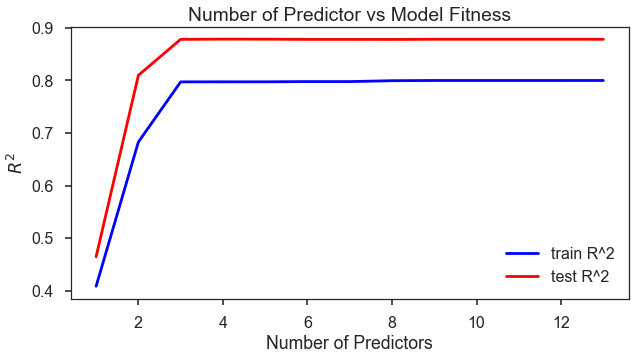

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(range(1, len(cols) + 1), train_R_sq, color='blue', label='train R^2')
ax.plot(range(1, len(cols) + 1), test_R_sq, color='red', label='test R^2')

ax.set_title('Number of Predictor vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('$R^2$')
ax.legend(loc='best')

plt.show()

---

## Multiple Linear Regresssion with Interaction Terms

In [95]:
y_train = train['Fare_amount'].values
X_train = train[['Trip Length (min)', 'Type', 'TMAX']].values

y_test = test['Fare_amount'].values
X_test = test[['Trip Length (min)', 'Type', 'TMAX']].values

gen_cross_terms = PolynomialFeatures(degree=3, interaction_only=True)
cross_terms = gen_cross_terms.fit_transform(X_train)
X_train_with_cross = np.hstack((X_train, cross_terms))
cross_terms = gen_cross_terms.fit_transform(X_test)
X_test_with_cross = np.hstack((X_test, cross_terms))

In [96]:
multi_regression_model = LinearRegression(fit_intercept=True)
multi_regression_model.fit(X_train_with_cross, y_train)

train_MSE = np.mean((y_train - multi_regression_model.predict(X_train_with_cross))**2)
test_MSE = np.mean((y_test - multi_regression_model.predict(X_test_with_cross))**2)
print('The train MSE with interaction terms is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = multi_regression_model.score(X_train_with_cross, y_train)
test_R_sq = multi_regression_model.score(X_test_with_cross, y_test)
print('The train R^2 with interaction terms is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train MSE with interaction terms is 20.684408502798963, the test MSE is 12.071251307903424
The train R^2 with interaction terms is 0.7178745764948866, the test R^2 is 0.8385091756973324


In [97]:
multi_regression_model.fit(X_train, y_train)

train_MSE = np.mean((y_train - multi_regression_model.predict(X_train))**2)
test_MSE = np.mean((y_test - multi_regression_model.predict(X_test))**2)
print('The train MSE without interaction terms is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = multi_regression_model.score(X_train, y_train)
test_R_sq = multi_regression_model.score(X_test, y_test)
print('The train R^2 without interaction terms is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train MSE without interaction terms is 23.25038469966132, the test MSE is 14.181236821686534
The train R^2 without interaction terms is 0.6828758903518493, the test R^2 is 0.8102815055746478


---

## Polynomial Regression

In [98]:
y_train = train['Fare_amount'].values
X_train = train[['Trip Length (min)', 'Type', 'TMAX']].values

y_test = test['Fare_amount'].values
X_test = test[['Trip Length (min)', 'Type', 'TMAX']].values

gen_poly_terms = PolynomialFeatures(degree=2, interaction_only=False)
X_train_with_poly = gen_poly_terms.fit_transform(X_train)
X_test_with_poly = gen_poly_terms.fit_transform(X_test)

In [99]:
poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_with_poly, y_train)

train_MSE= np.mean((y_train - poly_regression_model.predict(X_train_with_poly))**2)
test_MSE= np.mean((y_test - poly_regression_model.predict(X_test_with_poly))**2)
print('The train MSE for degree 2 poly model is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = poly_regression_model.score(X_train_with_poly, y_train)
test_R_sq = poly_regression_model.score(X_test_with_poly, y_test)
print('The train R^2 for degree 2 poly model is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train MSE for degree 2 poly model is 20.659112265092727, the test MSE is 11.93769411866508
The train R^2 for degree 2 poly model is 0.7182196050595173, the test R^2 is 0.8402959217463957


### Effect of Polynomial Degree on Model Performance

In [100]:
train_R_sq = []
test_R_sq = []
max_deg = 10

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

for d in range(max_deg + 1):

    out = d * 1. / max_deg * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()

    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
    X_train_with_poly = gen_poly_terms.fit_transform(X_train)
    X_test_with_poly = gen_poly_terms.fit_transform(X_test)
    
    poly_regression_model = LinearRegression(fit_intercept=False)
    poly_regression_model.fit(X_train_with_poly, y_train)
    
    train_R_sq.append(poly_regression_model.score(X_train_with_poly, y_train))
    test_R_sq.append(poly_regression_model.score(X_test_with_poly, y_test))
    
sys.stdout.write("\r%d%%" % 100)

100%

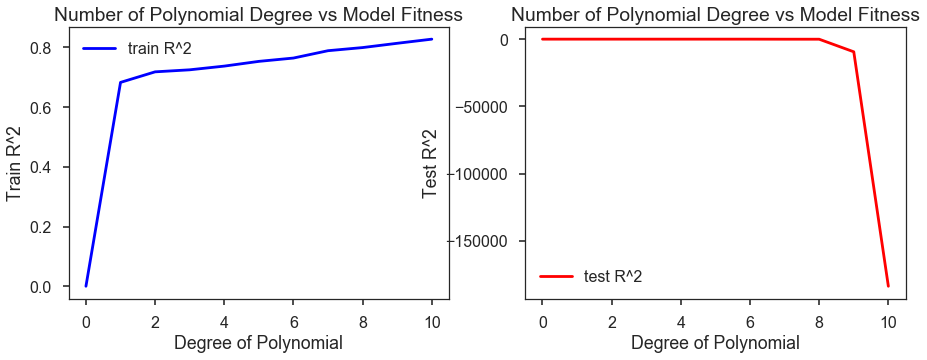

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(max_deg + 1), np.array(train_R_sq), color='blue', label='train R^2')

ax[0].set_title('Number of Polynomial Degree vs Model Fitness')
ax[0].set_xlabel('Degree of Polynomial')
ax[0].set_ylabel('Train R^2')
ax[0].legend(loc='best')

ax[1].plot(range(max_deg + 1), test_R_sq, color='red', label='test R^2')

ax[1].set_title('Number of Polynomial Degree vs Model Fitness')
ax[1].set_xlabel('Degree of Polynomial')
ax[1].set_ylabel('Test R^2')
ax[1].legend(loc='best')


plt.show()